# Single point analysis of least-cost paths

Here we pick a single point, in Tasmania, and find the least-cost path to all other points on the island.
It is then visualised, so we can ensure things are making sense.

Most of the time, we'd want to just get the cost of all paths to a point, using the `get_from_point` function, but here we just look at how the algorithm works for a single point.

In [1]:
import meshio
import numpy as np
from multiprocessing import Pool
import time

from ugs import *

# Need to make sure it's installed: pip3 install line_profiler
%load_ext line_profiler

In [2]:
#infile = "australia/data/TAS.vtk"
infile = "earth/data/globe.vtk"

mesh = meshio.read(infile)

In [3]:
max_distance = 3500  # how far should we go from the initial point?
starting_point = 66772   # Pick a point from the TAS.vtk
near_point = 147       # Pick another point, which is relatively close to the starting_point, just for testing

In [4]:
# We need to define a way to calculate cost
def distance_with_elevation_scaled(mesh, current, _next):
    # The travel_cost can be any function, including just the distance.
    # Here, we exagerate the elevation difference, to make changing elevation more costly
    if current == _next:
        return 0
    
    z_scaling = 100.  # 100. is a random number to pick, but has quite a big impact on the resulting paths.
    
    new_current = np.append(mesh.points[current][:2], mesh.point_data['Z'][current] * z_scaling)
    new_next    = np.append(mesh.points[_next][:2],   mesh.point_data['Z'][_next]   * z_scaling)
    
    return int(np.linalg.norm(new_current - new_next))  # return as Int, just for niceness

In [5]:
# We need to define a way to calculate cost
@functools.lru_cache(maxsize=1048576)
def elevation_only(mesh, current, _next):
    # Only take into account elevation changes for costs
    if current == _next:
        return 0
    return int(abs(mesh.point_data['Z'][current] - mesh.point_data['Z'][_next]) + distance(mesh, current, _next)*0.004)

In [6]:
# Choose which cost function you want
travel_cost = elevation_only

In [7]:
travel_cost(mesh, starting_point, near_point)  # Test the travel_cost function between two points

25396

In [8]:
distance(mesh, starting_point, near_point)  # Test the distance function between two points

5452296

In [9]:
%lprun -m ugs -f cost_search cost_search(mesh, starting_point, travel_cost, max_distance)

In [10]:
# Do the least-cost path calculations, and get back the data
#came_from, cost_so_far = cost_search(mesh, starting_point, travel_cost_function = travel_cost, max_distance = max_distance)
came_from, cost_so_far, dist_so_far = cost_search(mesh, starting_point, travel_cost_function = travel_cost, max_fuel = max_distance)

## Data structures

### came_from
`came_from` is a dictionary, where the keys are point IDs, and the value is the point ID of the point it came_from.

In [11]:
# Show some of the came_from data structure
count = 0
num_points_to_show = 80
for point, preceeding_point in came_from.items():
    print(str(point) + "\tcame from\t" + str(preceeding_point))
    if count > num_points_to_show:
        break
    count +=1

543744	came from	117724
543745	came from	413302
543746	came from	413307
543747	came from	209739
543753	came from	300804
543754	came from	238450
165899	came from	262579
165900	came from	413317
543757	came from	13876
543759	came from	271740
117776	came from	487733
543761	came from	117726
183314	came from	146509
543763	came from	33503
543764	came from	23747
543766	came from	487695
543767	came from	99939
543769	came from	164610
543770	came from	385598
183323	came from	364407
543772	came from	99940
543774	came from	300800
543776	came from	117730
543777	came from	300802
543778	came from	175857
167971	came from	256857
167972	came from	49407
45094	came from	271581
167975	came from	79150
397352	came from	300800
397354	came from	51786
43051	came from	175867
43053	came from	543772
397361	came from	397352
364405	came from	41750
543806	came from	23751
543807	came from	209748
543809	came from	543807
543810	came from	487672
618507	came from	99935
45128	came from	295210
45129	came from	271732
146509	c

You can see above that point `199` "came_from" `None`, since it was the initial point. 

This also means you can pick a point, e.g., `47`, and follow it back until you reach the starting point, AKA, when the `came_from` value is `None`.

In [12]:
# follow a single chain back to the origin point

point = came_from[list(came_from.keys())[-1]]                        # choose a start point
while point:                      # while point is not None
    print(str(point) + " -> ", end="")
    point = came_from[point]

117720 -> 543744 -> 117724 -> 271736 -> 45129 -> 271732 -> 271740 -> 165899 -> 262579 -> 43053 -> 543772 -> 99940 -> 172717 -> 49408 -> 290506 -> 66772 -> 

### cost_so_far

`cost_so_far` is also a dictionary, where the keys are point IDs, and the value is total cost it has taken to reach that point, from the starting point

In [13]:
# the cost to get from the starting point, 199, to the random point 47:
point = came_from[list(came_from.keys())[-1]]                        # choose a start point
print(cost_so_far[point])

3232


In [14]:
# Show the progressive cost of going from a point to the starting point
point = came_from[list(came_from.keys())[-1]]                        # choose a start point
while point:                      # while point is not None
    print(str(cost_so_far[point]) + " -> ", end="")
    point = came_from[point]

3232 -> 3115 -> 2656 -> 2363 -> 2208 -> 2055 -> 1910 -> 1736 -> 1383 -> 1075 -> 649 -> 488 -> 359 -> 230 -> 115 -> 0 -> 

## Show a map of all shortest paths

Since all paths have to lead back to the starting point, we can map out each of their paths by finding edge nodes, and then following the `came_from` paths back to the starting point.

In [15]:
# Find all the nodes that are at the edge of the tree
edge_nodes = []

for k in came_from.keys():             # For all the points we've visited,
    if k not in came_from.values():    # Find all the points that haven't been 'came_from'
        edge_nodes.append(k)
        
print(edge_nodes)

[543747, 543757, 117776, 543761, 543763, 543766, 543769, 543774, 543777, 543778, 167972, 45094, 397354, 397361, 543809, 146512, 146522, 146524, 7261, 543762, 412862, 133313, 23746, 266265, 364401, 543913, 219335, 543920, 412851, 219318, 412858, 412865, 133314, 23752, 219338, 219339, 219341, 543780, 219354, 219358, 271583, 397351, 487676, 543786, 487681, 487690, 587022, 587024, 487698, 487705, 543756, 487707, 487711, 487712, 487718, 487724, 487734, 487736, 487772, 487775, 487776, 487779, 271731, 271733, 271734, 271737, 312702, 228739, 79268, 262570, 250286, 262582, 199119, 72168, 300797, 18930, 243230, 385597, 385606, 385607, 385611, 385612, 385622, 99941, 99949, 413303, 413304, 413305, 413310, 413314, 413315, 413318, 28630, 117700, 300799, 440177, 117703, 543693, 290512, 586969, 543782, 733, 4389, 99965, 300796, 28629, 300805, 300807, 117722, 325422, 325431, 209738, 364393, 364394, 364400, 238452, 238453, 364406, 440195, 543623, 543627, 543638, 543639, 543649, 117684, 117689, 618436, 6

In [16]:
# For each edge node, follow the path back to the starting point, and keep track of the points and costs along the way
paths = []
costs = []
for p in edge_nodes:
    point = p
    cost = 0
    new_points = []
    new_costs = []
    while point:
        new_points.append(mesh.points[point])  # note, the points are being pulled from the VTK, so we get all their info
        new_costs.append(cost_so_far[point])
        point = came_from[point]

    new_points = np.array(new_points)
    new_costs  = np.array(new_costs)
    paths.append(new_points)
    costs.append(new_costs)

In [17]:
# Find the highest cost path
max_cost = max([max(c) for c in costs])
print(max_cost)

3500


In [18]:
total_dist = 0
for k in came_from.keys():             # For all the points we've visited,
    if k not in came_from.values():    # Find all the points that haven't been 'came_from'
        total_dist += dist_so_far[k]
print(total_dist)

48136299


<IPython.core.display.Javascript object>


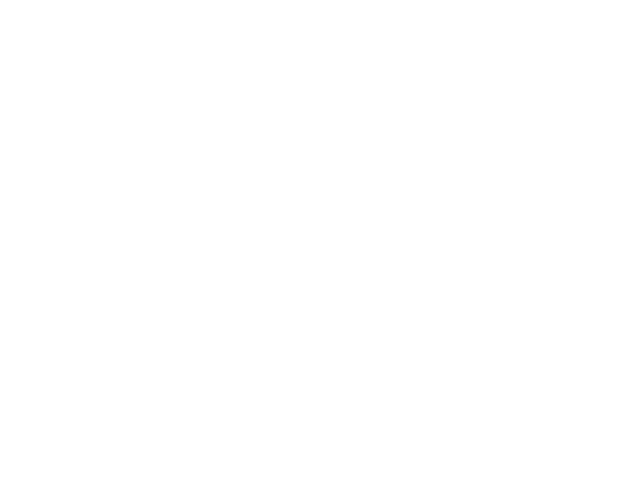

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [19]:
# Visualise all the paths back to the starting point, with colours showing the cost along the way

%matplotlib notebook
import matplotlib.pyplot as plt

norm = plt.Normalize(0, max_cost)
for p, c in zip(paths, costs):    
    plt.plot(p[:,0], p[:,1], c='k', zorder=0)
    plt.scatter(p[:,0], p[:,1], c=c, norm=norm, zorder=1)
    
plt.colorbar()
plt.axes().set_aspect('equal', 'datalim')

<IPython.core.display.Javascript object>


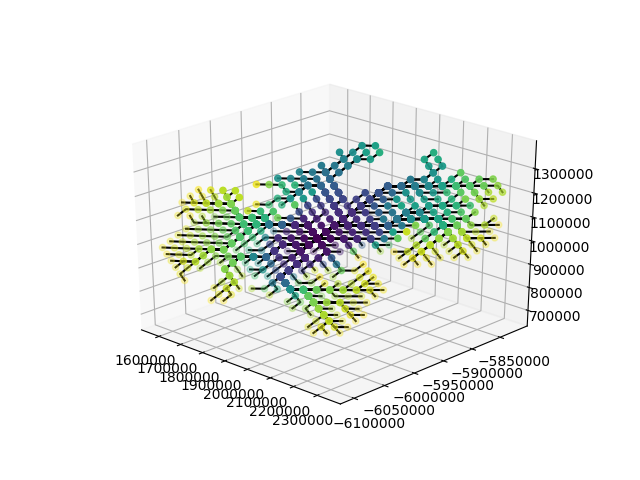

In [20]:
# Visualise all the paths back to the starting point, with colours showing the cost along the way

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

norm = plt.Normalize(0, max_cost)
for p, c in zip(paths, costs):    
    ax.plot(p[:,0], p[:,1], p[:,2], c='k', zorder=0)
    ax.scatter(p[:,0], p[:,1], p[:,2], c=c, norm=norm, zorder=1)
    
#plt.colorbar()
#plt.axes().set_aspect('equal', 'datalim')